In [ ]:
%pip install opencv-python albumentations segmentation-models==1.0.1 tensorflow==2.10 

   ---------------------------------------- 0.0/455.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/455.9 MB 6.6 MB/s eta 0:01:09
   ---------------------------------------- 2.4/455.9 MB 8.4 MB/s eta 0:00:55
   ---------------------------------------- 4.7/455.9 MB 9.2 MB/s eta 0:00:50
    --------------------------------------- 7.6/455.9 MB 11.2 MB/s eta 0:00:41
    --------------------------------------- 10.2/455.9 MB 11.2 MB/s eta 0:00:40
   - -------------------------------------- 12.6/455.9 MB 11.4 MB/s eta 0:00:39
   - -------------------------------------- 15.5/455.9 MB 11.9 MB/s eta 0:00:38
   - -------------------------------------- 18.1/455.9 MB 11.9 MB/s eta 0:00:37
   - -------------------------------------- 20.4/455.9 MB 11.8 MB/s eta 0:00:37
   -- ------------------------------------- 23.1/455.9 MB 12.0 MB/s eta 0:00:37
   -- ------------------------------------- 25.2/455.9 MB 11.8 MB/s eta 0:00:37
   -- ------------------------------------- 27.8/455.9 M

In [39]:
import os
import numpy as np
import tensorflow as tf
import albumentations as A
import cv2
import matplotlib.pyplot as plt

# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Configuration Class
class Config:
    # Dataset Paths
    BASE_PATH = 'C:/Users/ziade/Desktop/File Directory/tensorflowActivation/RD/seg/images'
    TRAIN_IMAGES = os.path.join(BASE_PATH, 'images/train')
    TRAIN_MASKS = os.path.join(BASE_PATH, 'color_labels/train')
    VAL_IMAGES = os.path.join(BASE_PATH, 'images/val')
    VAL_MASKS = os.path.join(BASE_PATH, 'color_labels/val')

    # Training Hyperparameters
    IMAGE_HEIGHT = 512
    IMAGE_WIDTH = 512
    BATCH_SIZE = 3
    EPOCHS = 50
    LEARNING_RATE = 1e-4
    NUM_CLASSES = 19

    # Label Colors (RGB)
    LABEL_COLORS = {
        'road': [128, 64, 128],
        'sidewalk': [244, 35, 232],
        'building': [70, 70, 70],
        'wall': [102, 102, 156],
        'fence': [190, 153, 153],
        'pole': [153, 153, 153],
        'traffic light': [250, 170, 30],
        'traffic sign': [220, 220, 0],
        'vegetation': [107, 142, 35],
        'terrain': [152, 251, 152],
        'sky': [70, 130, 180],
        'person': [220, 20, 60],
        'rider': [255, 0, 0],
        'car': [0, 0, 142],
        'truck': [0, 0, 70],
        'bus': [0, 60, 100],
        'train': [0, 80, 100],
        'motorcycle': [0, 0, 230],
        'bicycle': [119, 11, 32]
    }

# Data Loader (unchanged)
class BDD100kDataLoader(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, config, augment=False, is_training=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.config = config
        self.augment = augment
        self.is_training = is_training
        self.indexes = np.arange(len(self.image_paths))

        # Augmentation
        self.train_aug = A.Compose([
            A.RandomCrop(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.RandomGamma(p=0.2),
            A.GaussNoise(p=0.1),
        ])

        self.val_aug = A.Compose([
            A.CenterCrop(config.IMAGE_HEIGHT, config.IMAGE_WIDTH)
        ])

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.config.BATCH_SIZE)))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.config.BATCH_SIZE:(index+1)*self.config.BATCH_SIZE]
        batch_images = []
        batch_masks = []

        for i in batch_indexes:
            # Load Image
            image = cv2.imread(self.image_paths[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Load Mask
            mask = cv2.imread(self.mask_paths[i])
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            # Augmentation
            if self.is_training and self.augment:
                augmented = self.train_aug(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            elif not self.is_training:
                augmented = self.val_aug(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            # Normalize Image
            image = image.astype(np.float32) / 255.0

            # Create Segmentation Mask
            seg_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            for idx, (label, color) in enumerate(self.config.LABEL_COLORS.items()):
                class_mask = np.all(mask == color, axis=-1)
                seg_mask[class_mask] = idx

            batch_images.append(image)
            batch_masks.append(seg_mask)

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# Metrics function (unchanged)
def fct_mean_iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersect = tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.not_equal(y_pred, y_true), tf.float32))

    iou = tf.reduce_sum(intersect) / (tf.reduce_sum(union) + tf.reduce_sum(intersect))
    return iou

# Training function
def train_unet():
    # Configuration
    config = Config()
    # Evaluate on test set
    model_path = 'C:/Users/ziade/Desktop/File Directory/tensorflowActivation/RD/unet_bdd100k.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    test_metrics = evaluate_model(model, config)

    return model, test_metrics

# Evaluation function (unchanged)
def evaluate_model(model, config):
    test_images = sorted(
        [os.path.join(config.BASE_PATH, 'images/test', f)
         for f in os.listdir(os.path.join(config.BASE_PATH, 'images/test'))
         if f.endswith('.jpg')]
    )
    test_masks = [
        os.path.join(config.BASE_PATH, 'color_labels/test', f.replace('.jpg', '_train_color.png'))
        for f in os.listdir(os.path.join(config.BASE_PATH, 'images/test'))
        if f.endswith('.jpg')
    ]

    test_generator = BDD100kDataLoader(
        test_images, test_masks, config,
        augment=False, is_training=False
    )

    evaluation_metrics = model.evaluate(test_generator)

    print("\nTest Evaluation:")
    for metric_name, metric_value in zip(model.metrics_names, evaluation_metrics):
        print(f"{metric_name}: {metric_value}")

    return dict(zip(model.metrics_names, evaluation_metrics))



In [54]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def predict_segmentation(model, image_path, config):
    """
    Perform semantic segmentation on a single input image.

    Args:
        model (tf.keras.Model): Trained U-Net model
        image_path (str): Path to the input image
        config (Config): Configuration object with label colors

    Returns:
        tuple: Original image, predicted segmentation mask, color-mapped segmentation
    """
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image to match model input
    original_shape = image.shape[:2]
    resized_image = cv2.resize(image, (config.IMAGE_WIDTH, config.IMAGE_HEIGHT))

    # Normalize
    input_image = resized_image.astype(np.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # Predict
    prediction = model.predict(input_image)[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    # Create color-mapped segmentation
    color_mask = np.zeros_like(resized_image)
    for idx, (label, color) in enumerate(config.LABEL_COLORS.items()):
        color_mask[predicted_mask == idx] = color

    # Resize back to original image size
    color_mask = cv2.resize(color_mask, (original_shape[1], original_shape[0]))

    # Blend original image with segmentation mask
    alpha = 0.5
    blended = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)

    return image, color_mask, blended

def visualize_segmentation(image, color_mask, blended, output_path='segmentation_result.png'):
    """
    Visualize segmentation results in a single figure.

    Args:
        image (np.ndarray): Original image
        color_mask (np.ndarray): Color-coded segmentation mask
        blended (np.ndarray): Blended image with segmentation overlay
        output_path (str): Path to save the visualization
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Segmentation Mask')
    plt.imshow(color_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Blended Image')
    plt.imshow(blended)
    plt.axis('off')

    plt.tight_layout()

def inference_demo(model_path='C:/Users/ziade/Desktop/File Directory/tensorflowActivation/RD/unet_bdd100k.h5'):
    """
    Demonstrate model inference on a sample image.

    Args:
        model_path (str): Path to the saved model
    """
    # Load model
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'mean_iou': fct_mean_iou}
    )

    # Configuration
    config = Config()

    # Sample image path (modify this to your test image)
    test_image_path = os.path.join('C:/Users/ziade/Desktop/File Directory/tensorflowActivation/RD/download3.jpg')

    # Perform segmentation
    original, color_mask, blended = predict_segmentation(model, test_image_path, config)

    # Visualize results
    visualize_segmentation(original, color_mask, blended)



1/1 [==============================] - 0s 272ms/step


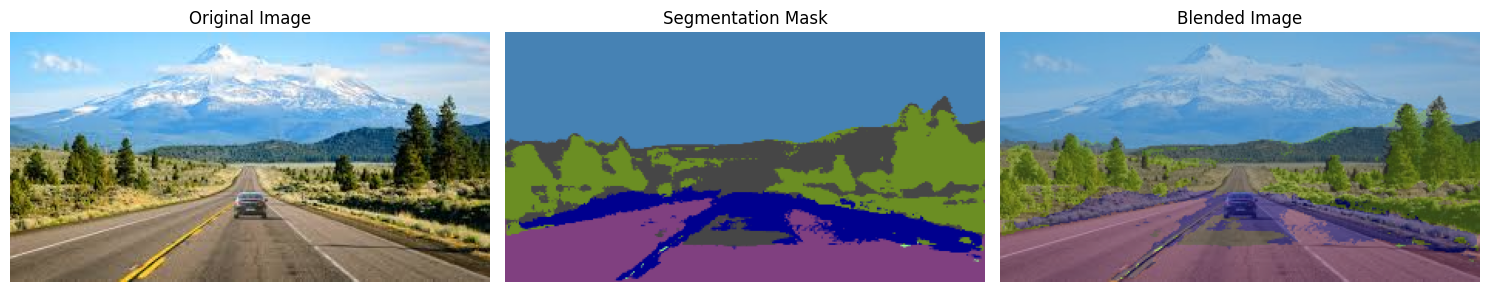

In [55]:
inference_demo()

1/1 [==============================] - 0s 16ms/step


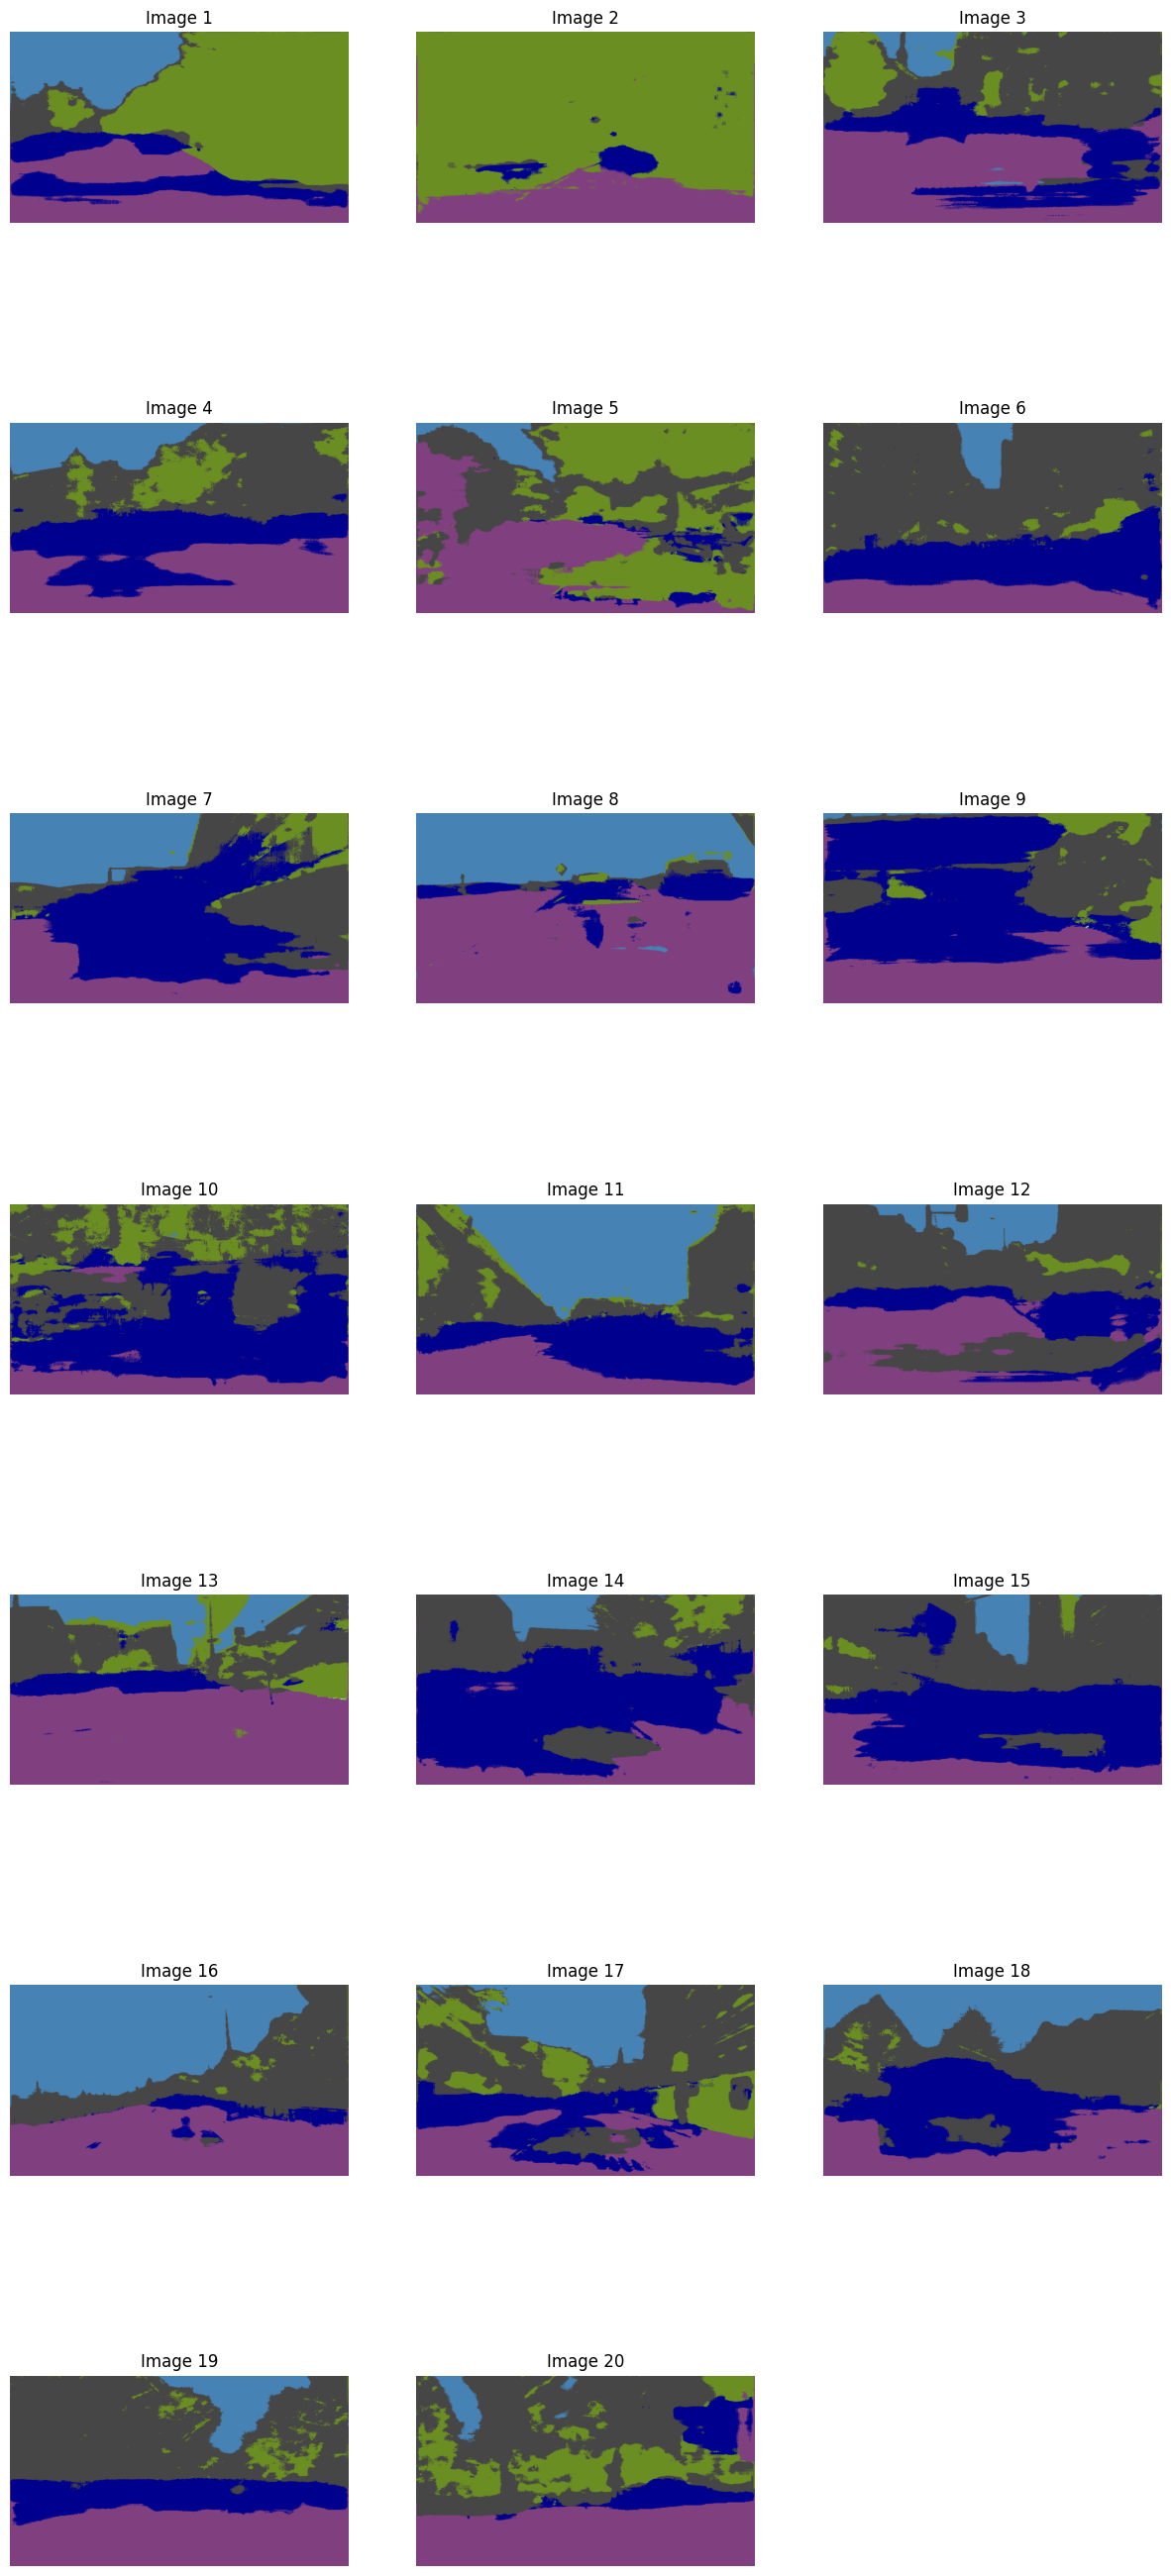


Sample Evaluation:
7/7 [==============================] - 3s 248ms/step - loss: 1.2153 - mean_iou: 0.6325
loss: 1.2153043746948242
mean_iou: 0.6325372457504272


In [57]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random

def predict_segmentation(model, image_path, config):
    """
    Perform semantic segmentation on a single input image.

    Args:
        model (tf.keras.Model): Trained U-Net model
        image_path (str): Path to the input image
        config (Config): Configuration object with label colors

    Returns:
        tuple: Original image, predicted segmentation mask, color-mapped segmentation
    """
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image to match model input
    original_shape = image.shape[:2]
    resized_image = cv2.resize(image, (config.IMAGE_WIDTH, config.IMAGE_HEIGHT))

    # Normalize
    input_image = resized_image.astype(np.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0)

    # Predict
    prediction = model.predict(input_image)[0]
    predicted_mask = np.argmax(prediction, axis=-1)

    # Create color-mapped segmentation
    color_mask = np.zeros_like(resized_image)
    for idx, (label, color) in enumerate(config.LABEL_COLORS.items()):
        color_mask[predicted_mask == idx] = color

    # Resize back to original image size
    color_mask = cv2.resize(color_mask, (original_shape[1], original_shape[0]))

    # Blend original image with segmentation mask
    alpha = 0.5
    blended = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)

    return image, color_mask, blended

def visualize_multiple_segmentations(results):
    """
    Visualize segmentation results for multiple images.

    Args:
        results (list): List of tuples containing (original, color_mask, blended) for each image
    """
    num_images = len(results)
    rows = (num_images + 2) // 3  # Calculate number of rows needed
    
    plt.figure(figsize=(15, 5 * rows))
    
    for i, (original, color_mask, blended) in enumerate(results, 1):
        plt.subplot(rows, 3, i)
        plt.title(f'Image {i}')
        plt.imshow(original)
        plt.imshow(color_mask)
        plt.axis('off')
    
    plt.show()

def inference_demo(model_path='C:/Users/ziade/Desktop/File Directory/tensorflowActivation/RD/unet_bdd100k.h5', sample_size=20):
    """
    Demonstrate model inference on a sample of test images and evaluate performance.

    Args:
        model_path (str): Path to the saved model
        sample_size (int): Number of test images to evaluate
    """
    # Load model
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'mean_iou': fct_mean_iou}
    )

    # Configuration
    config = Config()

    # Test image paths
    test_image_dir = os.path.join('C:/Users/ziade/Desktop/File Directory/tensorflowActivation/RD/seg/images/test')
    test_mask_dir = os.path.join('C:/Users/ziade/Desktop/File Directory/tensorflowActivation/RD/seg/color_labels/test')
    
    # Get all test image paths
    all_test_images = sorted([
        os.path.join(test_image_dir, f) 
        for f in os.listdir(test_image_dir) 
        if f.endswith('.jpg')
    ])
    
    all_test_masks = [
        os.path.join(test_mask_dir, f.replace('.jpg', '_train_color.png'))
        for f in os.listdir(test_image_dir)
        if f.endswith('.jpg')
    ]

    # Randomly sample test images
    random.seed(30)  # for reproducibility
    sample_indices = random.sample(range(len(all_test_images)), min(sample_size, len(all_test_images)))
    
    sample_images = [all_test_images[i] for i in sample_indices]
    sample_masks = [all_test_masks[i] for i in sample_indices]

    # Perform segmentation on sample images
    results = []
    for image_path in sample_images:
        original, color_mask, blended = predict_segmentation(model, image_path, config)
        results.append((original, color_mask, blended))

    # Visualize results
    visualize_multiple_segmentations(results)

    # Create a data loader for the sample
    sample_generator = BDD100kDataLoader(
        sample_images, sample_masks, config,
        augment=False, is_training=False
    )

    # Evaluate on the sample
    print("\nSample Evaluation:")
    evaluation_metrics = model.evaluate(sample_generator)

    # Print metrics
    for metric_name, metric_value in zip(model.metrics_names, evaluation_metrics):
        print(f"{metric_name}: {metric_value}")

    return model, results, evaluation_metrics

# Run the inference demo
model, results, metrics = inference_demo()